# Homorphic operations over Rige Classifier

## IRIS Data Set 
<p>This demo is using the well known IRIS data set.</p>
The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 

<b>Preparation steps:</b>
<ul>
<li>Load IRIS data set</li>
<li>Split the data set into training and testing sets</li>
<li>We will do a binary classification: Versicolor (class 2) vs the others</li>
<li>Will fit it with Ridge regression with alpha = 0.5 </li>
</ul>

In [340]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
iris = load_iris()

# split test set for prdictions
X_train, X_test, y_train, y_test = train_test_split(iris.data, 
                                iris.target, test_size=0.1, random_state=42)

y_train = (y_train == 2).astype(int)
y_test = (y_test == 2).astype(int)

clf = Ridge(fit_intercept=False, alpha = 0.5)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

## Determine the value for threshold

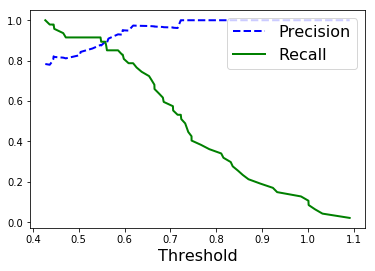

In [341]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper right", fontsize=16)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

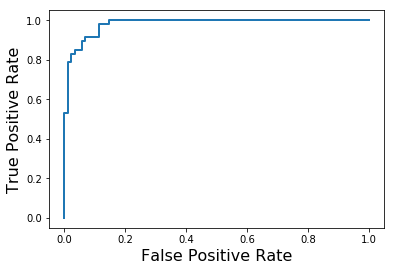

In [342]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

<b><i>The ROC curve converges at 0.9, so the threshold will be around 0.55 from the first chart</i></b>

In [343]:
threshold = .55

## Calculate the area under curve (AUC)  for the train set

In [344]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_pred > threshold)

0.9183994197292069

## AUC for testing set

In [345]:
y_test_pred = clf.predict(X_test)
roc_auc_score(y_test, y_test_pred > threshold)

1.0

<b><i>I implemented homorphic encryption only for signed integers so far, so we will use a scale factor to convert all data and coefficients to int_32</i></b>

## Scale the coefficents, data and threshold

In [346]:
scale = 10000
coef_scaled = (clf.coef_ * scale).astype(int)
X_test_scaled = (X_test * scale).astype(int)
threshold_scaled = int( threshold * scale * scale )

## Verify that the scaling did not break any results

In [347]:
# Ridge predictor for sklearn
(y_test_pred > threshold).astype(int).tolist()

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

In [348]:
# manual product computation
[ int(sum(clf.coef_ * X_test[i,:]) > threshold) for i in range(X_test.shape[0]) ]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

In [349]:
# scaled data manual product computation
[ int(sum(coef_scaled * X_test_scaled[i,:]) > threshold_scaled) for i in range(X_test_scaled.shape[0]) ]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

# Homorphic Implemention for Ridge evaluation

## Define homomorphic functions

In [350]:
import requests
# Kuberantis TD Homomorphic encryption service
baseUrl = 'http://13.68.227.239/v1'

def encrypt(v):
    return requests.post(baseUrl + '/encrypt', params=dict(pubKey='alex', value=v)).json()['encrypted']
def decrypt(c):
    return requests.post(baseUrl + '/decrypt', params=dict(key='alex', value=c)).json()['value']
def compare(c1, c2):
    return requests.post(baseUrl + '/compare', params=dict(pubKey='alex', c1=c1, c2=c2)).json()['encrypted']
def product(a1, a2):
    pairs= list(map (lambda a: dict(v1=a[0], v2=a[1]), zip(a1, a2)))
    return requests.post(baseUrl + '/product', json=dict(pubKey='alex', pairs=pairs)).json()['encrypted']

## Encrypt all test data

In [380]:
enc_vector_fn = lambda i: list(map(lambda a:  encrypt(a), X_test_scaled[i,:] ))

X_test_enc = [enc_vector_fn(i) for i in range(X_test_scaled.shape[0])]

In [381]:
enc_coef = list(map(lambda a:  encrypt(a), coef_scaled ))

## Encrypt all coefficents

In [382]:
threshold_enc = encrypt(threshold_scaled)

## Calculate the dot product over encrypted data and coefficients

In [383]:
result_encrypted = [ compare(product(enc_coef, X_test_enc[i]),threshold_enc)
                    for i in range(X_test_scaled.shape[0]) ]

## Decrypt final results

In [384]:
homomorphic_decrypted = list(map(lambda a: decrypt(a), result_encrypted))
homomorphic_decrypted

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

## Compare with the Ridge model output from sklearn

In [385]:
(y_test_pred > threshold).astype(int).tolist()

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

# Conclusion

Homomorphic encryption could be used in Linear models to hide coefficients and data. It will allow cryptographically separate a model and data.

This allows one organization to evaluate its model over hidden data of the other organization. The computing organization does not see data and results. The other organization does not see the model structure and its coefficients.